# Wet vs. Dry Subset Comparison

## Setup

In [ ]:
# Import statements
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.delayed import delayed
from dask.base import compute
from metpy.plots import ctables
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
from typing import List
import scienceplots # noqa: F401

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True
mpl.rcParams["hatch.linewidth"] = 0.2

In [14]:
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


# Function to overwrite ne values
def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    da["ne"] = range(5)
    return da


def process_dim(da: xr.DataArray) -> xr.DataArray:
    """Helper function to process DataArray with or without time dimension"""
    ens_mean = da.mean(dim="run").stack(i=("lat", "lon"))
    sorted_mean = ens_mean.sortby(ens_mean)
    sorted_all = np.sort(da.values.flatten())[:: len(da.run)]
    sorted_mean.values = sorted_all
    return sorted_mean.unstack("i")


def pmm(da: xr.DataArray) -> xr.DataArray:
    """Compute the probability matched mean of a DataArray"""
    if "time" in da.dims:
        results = []
        for time_slice in da.time:
            time_da = da.sel(time=time_slice)
            results.append(process_dim(time_da))
        return xr.concat(results, dim="time")
    else:
        return process_dim(da)


@delayed
def bootstrap_iteration(da: xr.DataArray, sample_size: int) -> xr.DataArray:
    """Single iteration of bootstrapping"""
    # Sample without replacement
    sample1 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))
    sample2 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))

    # Compute PMM for each sample
    pmm1 = pmm(sample1)
    pmm2 = pmm(sample2)

    # Compute difference of PMMs
    diff = pmm1 - pmm2
    return diff


def bootstrap_pmm_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of PMM"""
    tasks = [bootstrap_iteration(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")


In [4]:
# Read in 2000- 2300 UTC initializations
wofs_all = [get_wofs_all(i) for i in [20, 21, 22, 23]]

# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init")
init = init.assign_coords({"init": init})

lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # this is the projection that WoFS uses

# Get MetPy precipitation colortable
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")


## Create Subsets

In [6]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_aoi]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]


In [7]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]


### Precipitation

In [18]:
# Prepare 01-02 UTC rainfall
rain12_all = rain12.stack(run=("init", "ne")).chunk({"run": -1})
rain12_wet = (
    get_total_field(
        wofs_wet, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
    )
    .chunk("auto")
    .stack(run=("init", "ne"))
)
rain12_dry = (
    get_total_field(
        wofs_dry, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
    )
    .chunk("auto")
    .stack(run=("init", "ne"))
)


In [19]:
# Get difference in probability matched mean
diff = pmm(rain12_wet) - pmm(rain12_dry)

# Find bootstrapped statistical significance
quantiles = (
    bootstrap_pmm_difference(rain12_all, sample_size=20, iterations=1000)
    .quantile([0.05, 0.95], dim="iteration")
    .compute()
)

# Mask where values > 95th percentile or < 5th percentile
mask = (diff < quantiles.sel(quantile=0.05).squeeze()) | (  # type: ignore
    diff > quantiles.sel(quantile=0.95).squeeze()  # type: ignore
)

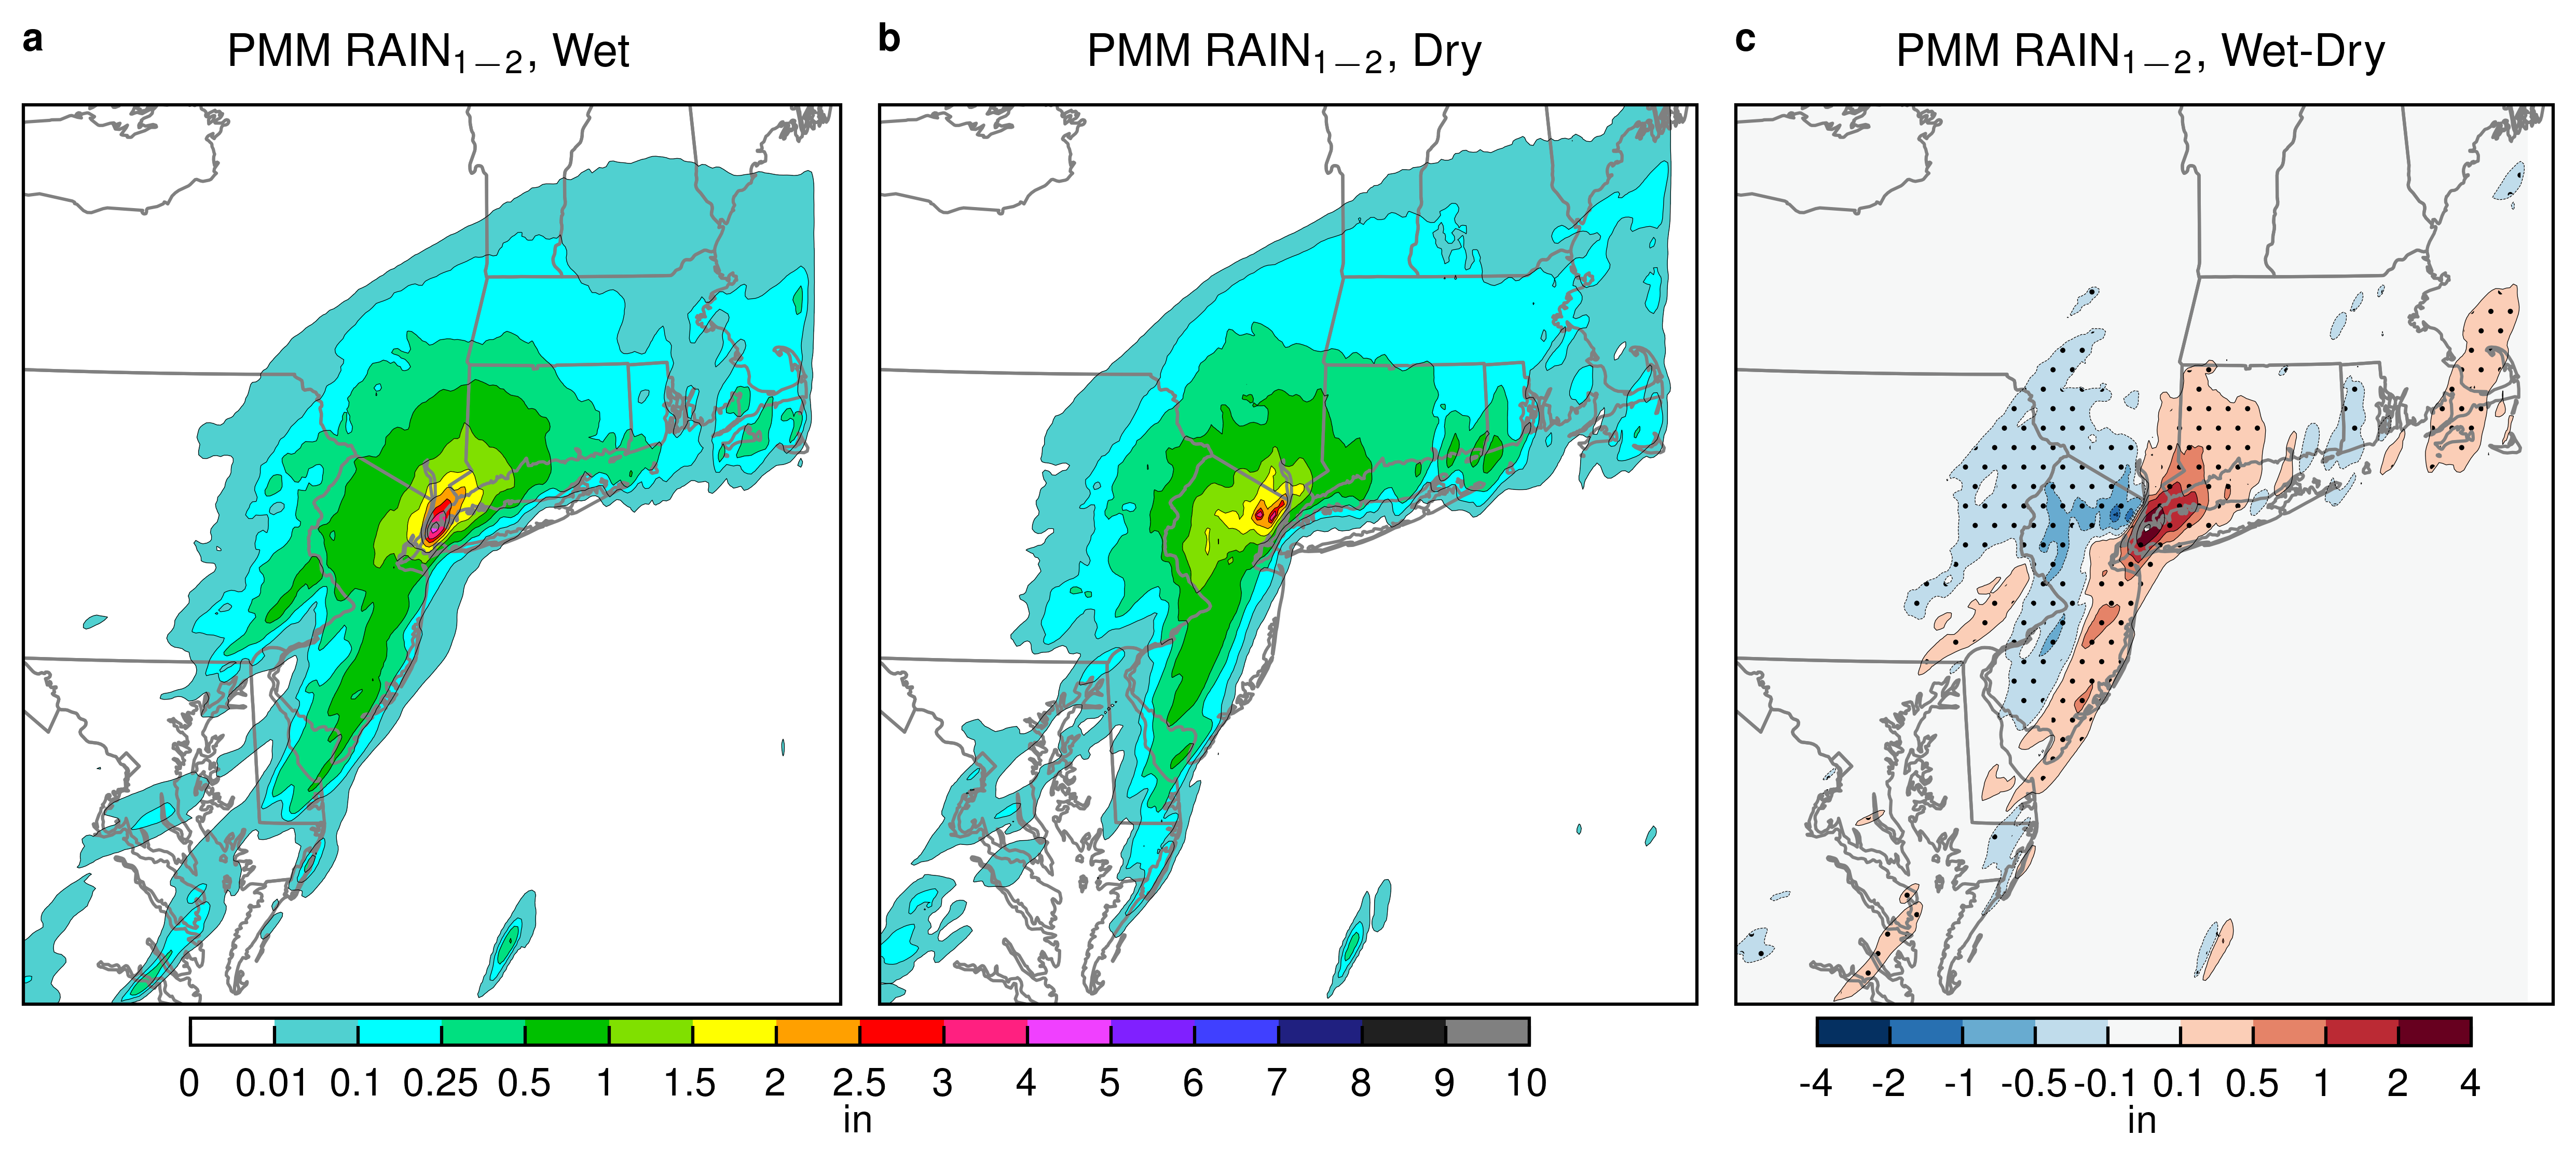

In [59]:
rain_values = [r.load() for r in [pmm(rain12_wet), pmm(rain12_dry), diff]]
titles = ["PMM RAIN$_{1-2}$, Wet", "PMM RAIN$_{1-2}$, Dry", "PMM RAIN$_{1-2}$, Wet-Dry"]
levels = [0, 0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]
diff_levels = [-4, -2, -1, -0.5, -0.1, 0.1, 0.5, 1, 2, 4]

# Create a normalization object
pnorm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=False)

fig, axes = plt.subplots(
    1,
    3,
    figsize=(5.5, 3),
    dpi=900,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

# Define colormap and normalization for the third panel
cmap = plt.get_cmap("RdBu_r")
dnorm = BoundaryNorm(
    [-4, -2, -1, -0.5, -0.1, 0.1, 0.5, 1, 2, 4], ncolors=cmap.N, clip=True
)

for i, ax in enumerate(axes.flatten()):
    if i != 2:
        c1 = ax.contourf(
            lon,
            lat,
            rain_values[i],
            cmap=precip_cmap,
            levels=levels,
            transform=ccrs.PlateCarree(),
            norm=pnorm,
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="gray")
        cn = ax.contour(
            lon,
            lat,
            rain_values[i],
            levels=levels[1:],
            transform=ccrs.PlateCarree(),
            colors="k",
            linewidths=0.1,
        )

    else:
        c2 = ax.contourf(
            lon,
            lat,
            rain_values[i],
            transform=ccrs.PlateCarree(),
            levels=diff_levels,
            cmap=cmap,
            norm=dnorm,
        )
        ax.contourf(
            lon,
            lat,
            mask.where(abs(rain_values[i]) > 0.1),
            transform=ccrs.PlateCarree(),
            levels=[0, 0.5, 1],
            hatches=["", "...."],
            colors="none",
        )
        cn = ax.contour(
            lon,
            lat,
            rain_values[i],
            levels=diff_levels[1:],
            transform=ccrs.PlateCarree(),
            colors="k",
            linewidths=0.1,
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="gray")

    ax.set_title(titles[i], fontsize=7)
    ax.set_extent([-78, -70, 37, 44])

cb1 = fig.colorbar(
    c1, ax=axes[0:2], orientation="horizontal", shrink=0.8, pad=0.01, aspect=50
)
cb1.ax.tick_params(labelsize=6)
cb1.set_ticks(levels)
cb1.set_ticklabels(levels)
cb1.set_label("in", fontsize=6, labelpad=0.1)

cb2 = fig.colorbar(
    c2, ax=axes[2], orientation="horizontal", shrink=0.8, pad=0.01, aspect=24
)
cb2.ax.tick_params(labelsize=6)
cb2.set_ticks(diff_levels)
cb2.set_ticklabels(diff_levels)
cb2.set_label("in", fontsize=6, labelpad=0.1)

letters = ["a", "b", "c"]
for i, ax in enumerate(axes.flatten()):
    ax.text(
        -0, 1.06, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=6
    )

plt.savefig("../final-figures/pmm-rain12.pdf", bbox_inches="tight")

plt.show()
